# A Case Study : Organosilicon Compounds

In [1]:
parameters = dict(
    subfrag_size = 12,
    edge_size = 3,
    out_size = 1,
    seed = 42,
    batch_size = 256,
    max_epoch = 200,
    verbose = True,
    save = False,
    
    target = 'HCOM',
    hidden_size = 256,
    dropout = 0.276,
    num_layers = 7,
    num_timesteps = 4,
    lr_init = 0.0001,
    gamma = 0.986,
    weight_decay = 6.72E-3,
)
DATAPATH = "/SSD2/bgkang/Chemomile"
MODELPATH = "../Model/HCOM-2024-07-17-04-48-42" # HCOM

In [2]:
import sys
sys.path.append(DATAPATH)
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from src.data import Dataset
from src.smiles2data import smiles2data
from src.model import Chemomile
from src.explainer import MultiExplainer

dataset = Dataset(target = parameters['target'], root = DATAPATH)
silicone = Dataset(target = 'ORGANOSILICONE', root = DATAPATH, batch_size = 16)

model = Chemomile(
            subfrag_size = parameters['subfrag_size'],
            hidden_size = parameters['hidden_size'],
            out_size = parameters['out_size'],
            edge_size = parameters['edge_size'],
            dropout = parameters['dropout'],
            num_layers = parameters['num_layers'],
            num_timesteps = parameters['num_timesteps'],
            )
model.load_state_dict(torch.load(MODELPATH))
model.eval()

	DataDump found for 'HCOM'. Loading dumped data.
Training : 727 | Validation : 91 | Test : 91
Total : 909
	DataDump found for 'ORGANOSILICONE'. Loading dumped data.
Training : 56 | Validation : 7 | Test : 8
Total : 71


Chemomile(
  (atom_encoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (subfrag_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (fragment_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (molecule_level): AttentiveFP(in_channels=256, hidden_channels=512, out_channels=256, edge_dim=3, num_layers=7, num_timesteps=4)
  (fully_connected): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.276, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [3]:
%%time
explainer = MultiExplainer(
    model = model,
    dataset = silicone
)

pred = explainer.ref * dataset.std + dataset.mean

scores = explainer.atomMask()

# XYZ File

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

SYMBOL = dict(
    [(1, "H"), (6, "C"), (8, "O"), (7, "N"), (9, "F"), (14, "Si"), (16, "S"), (17, "Cl"), (53, "I")]
)

def xyzWriter(numAtom, smiles, atomicNum, position, score):
    with open(f'./CaseStudy/{smiles.upper()}.xyz', 'w') as fp:
        fp.write(f"{numAtom}\n")
        fp.write(f"{smiles.upper()}\n")
        for i in range(numAtom):
            fp.write(f"{SYMBOL[atomicNum[i]]}\t{position[i,0]}\t{position[i,1]}\t{position[i,2]}\t{score[i]}\n")
    return

In [ ]:
for idx, data in enumerate(silicone.total_set):
    numAtom = int(data.numAtom)
    position = data.mol_x[:,-3:]
    atomicNum = data.mol_x[:,0].numpy().astype(int)
    smiles = data.smiles
    score = scores[idx]
    xyzWriter(numAtom, smiles, atomicNum, position, score)
print(">:D Done!")

>:D Done!


# Data Inspection

In [ ]:
final_result = []
for idx, data in enumerate(silicone.total_set):
    tempDict = {}
    tempDict['numAtom'] = int(data.numAtom)
    tempDict['atomicNum'] = data.mol_x[:,0].numpy().astype(int).tolist()
    tempDict['smiles'] = data.smiles
    tempDict['scores'] = scores[idx]
    final_result.append(tempDict)
len(final_result)

71

In [ ]:
atomic_contributions = {
    1 : [],
    6 : [],
    7 : [],
    8 : [],
    9 : [],
    14 : [],
    16 : [],
    17 : [],
    53 : [],
}

for data in final_result:
    for atomicNum, score in zip(data['atomicNum'], data['scores']):
        atomic_contributions[atomicNum].append(score)

print(len(atomic_contributions[1]))

1473


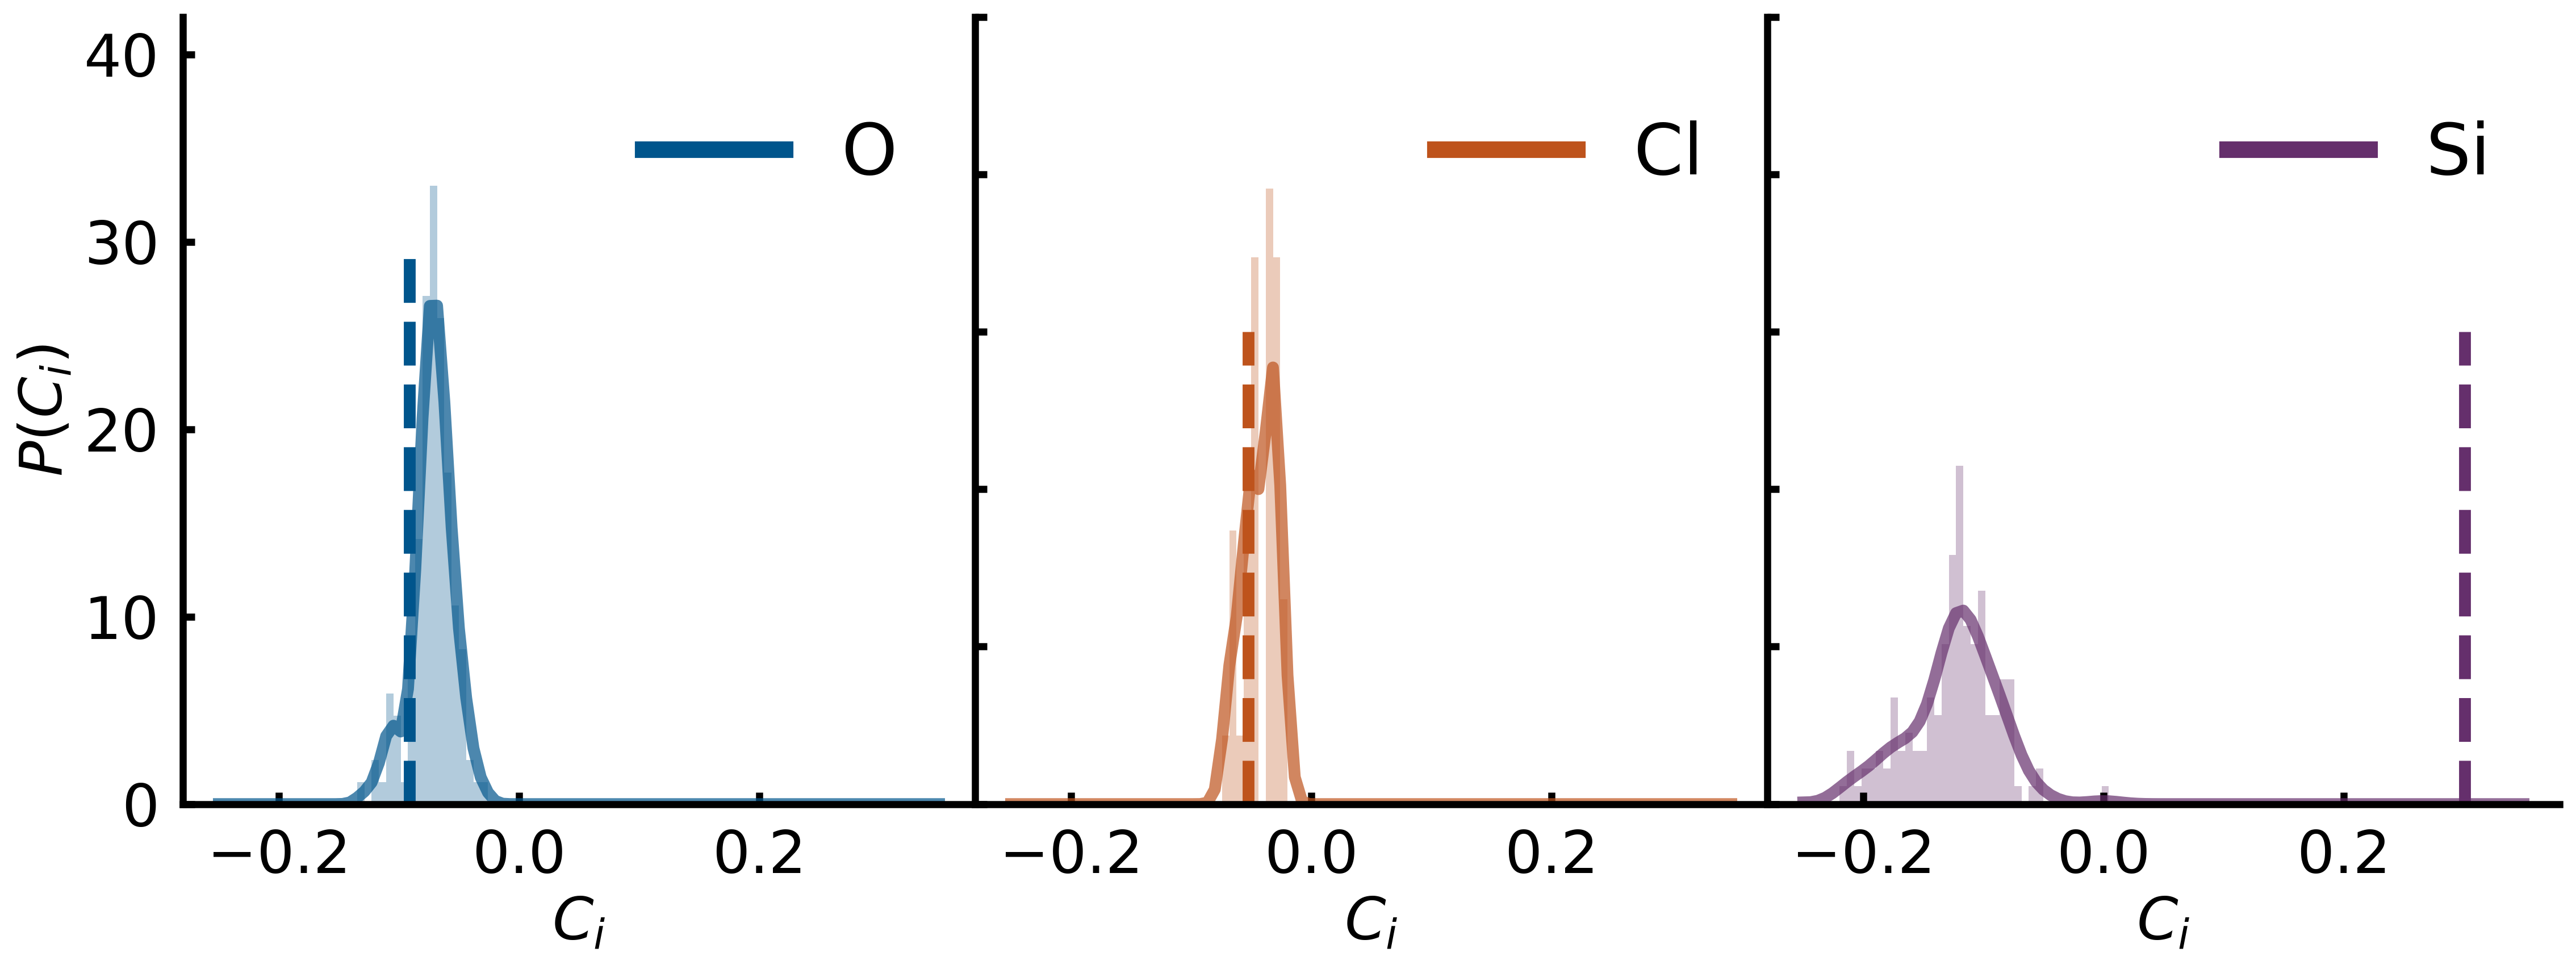

In [ ]:
# For Figure
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 3, figsize = (18, 6), dpi = 300)
plt.subplots_adjust(wspace=0, hspace=0)

LABELS = {1 : "H", 6 : "C", 7 : "N", 8 : "O", 9 : "F", 14 : "Si", 16 : "P", 17 : "Cl", 53 : "I"}
REF = {
    6 : 0.1379302805,
    8 : -0.09121295867, 
    9 : -0.128431818,
    16 : 0.1301488725,
    14 : 0.3009990106,
    17 : -0.05253736603,
    }
NUMBINS = 100
COLORMAP = {
    7 : "#AF272F",
    8 : "#00558C",
    9 : "#D38235",
    14 : "#652F6C",
    16 : "#719949",
    17 : "#BE531C"
}

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_linewidth(3)
    a.spines['left'].set_linewidth(3)
    a.set_ylim((0, 42))
    a.tick_params(labelsize = 25, pad = 10, direction = 'in', width = 3, length = 5)
    a.patch.set_alpha(0.00)

x = np.linspace(-0.25, 0.35, NUMBINS)

types = (8, 17, 14)
for idx, ty in enumerate(types):
    try:
        data = atomic_contributions[ty]
        kde = gaussian_kde(data)
        ax[idx].hist(data, bins = x, alpha = 0.3, density = True, color = COLORMAP[ty])
        ax[idx].plot(x, kde.evaluate(x), linewidth = 5, color = COLORMAP[ty], alpha = 0.7)
        ax[idx].vlines(REF[ty], 0, 30, linestyle = '--', color = COLORMAP[ty], linewidth = 5)
        ax[idx].plot([0],[0], linewidth = 7, color = COLORMAP[ty], label = LABELS[ty])
    except Exception as e:
        print(";)")
        print(e)

# ax[2].plot([0],[0], linewidth = 7, linestyle = '--', color = 'k', label = "Keshavarz et al.")

ax[1].set_yticks(ticks = ax[0].get_yticks(), labels = [])
ax[2].set_yticks(ticks = ax[0].get_yticks(), labels = [])
ax[0].set_ylabel("$P(C_i)$", fontsize = 25)

for a in ax:
    a.set_xlabel("$C_i$", fontsize = 25)
    a.legend(frameon = False, loc = 3, fontsize = 30, bbox_to_anchor = (0.5, 0.7))

plt.savefig("Ci_PDF.png", dpi = 300, bbox_inches = 'tight')

plt.show()

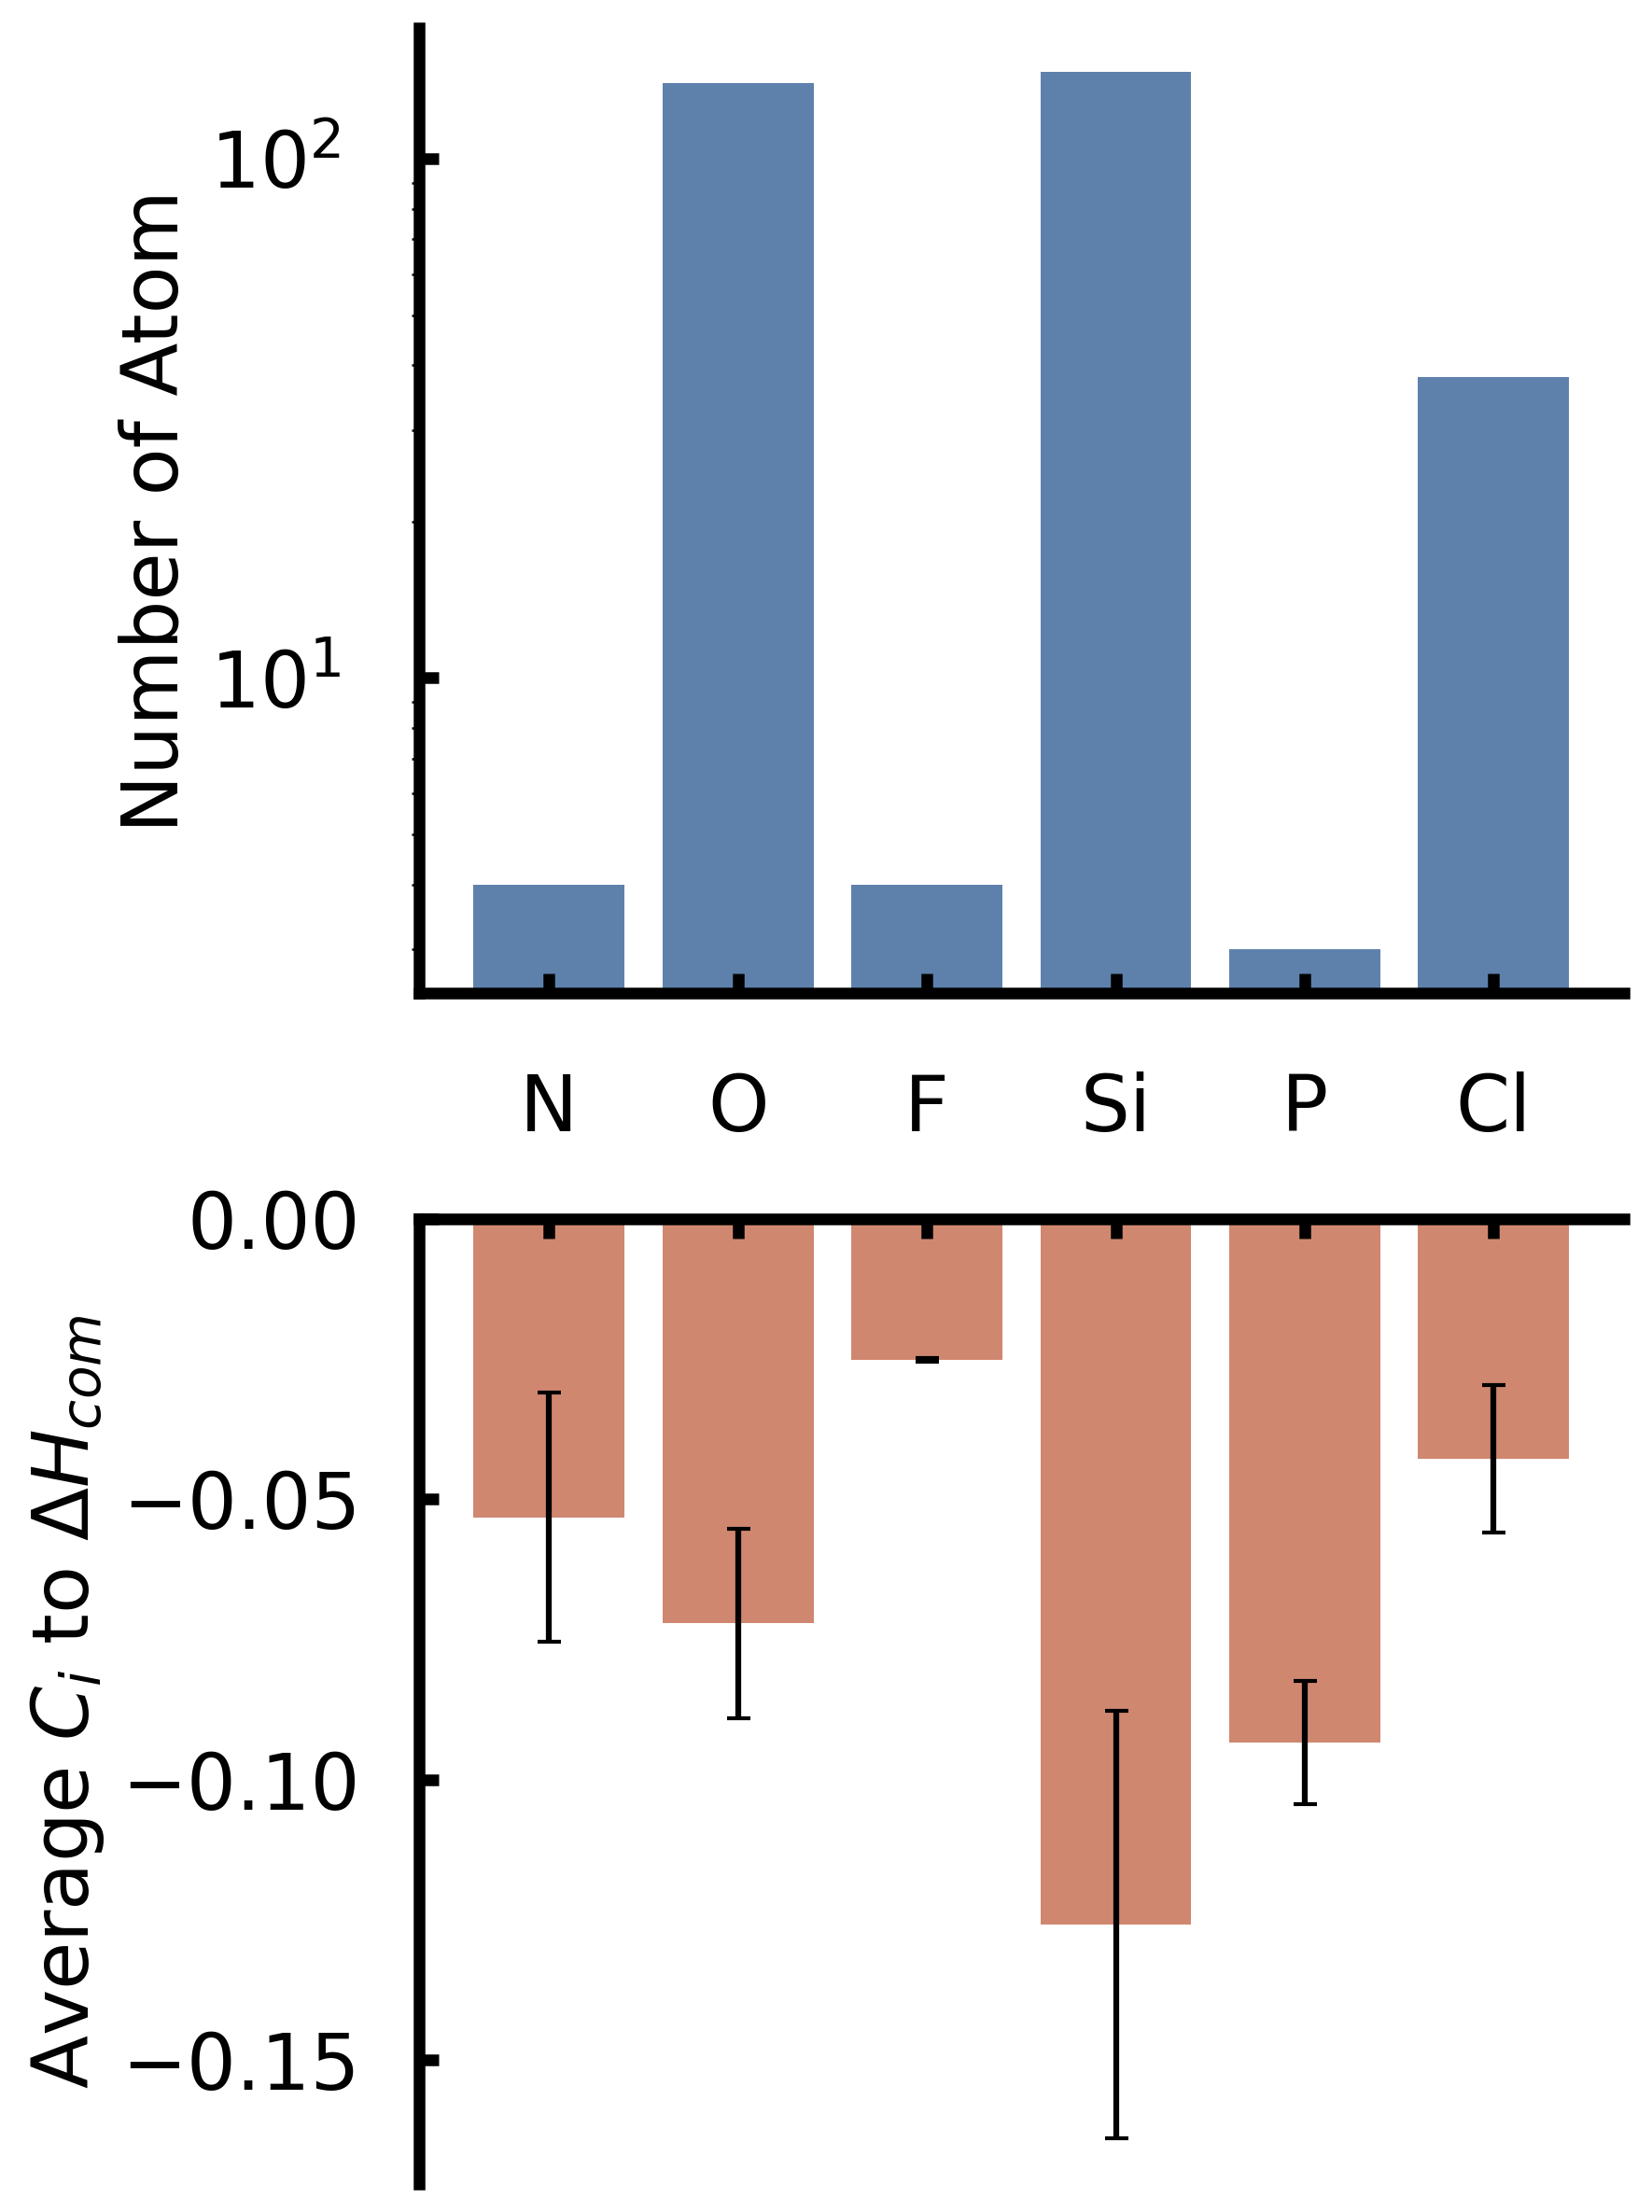

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(2, 1, figsize = (6, 8), dpi = 300)

selected_keys = (7, 8, 9, 14, 16, 17)

SYMBOL = {1 : "H", 6 : "C", 7 : "N", 8 : "O", 9 : "F", 14 : "Si", 16 : "P", 17 : "Cl", 53 : "I"}

data = dict(
    numPoint = dict([(atomicNum, len(atomic_contributions[atomicNum])) for atomicNum in selected_keys]),
    averaged = dict([(atomicNum, np.array(atomic_contributions[atomicNum]).mean()) for atomicNum in selected_keys]),
    std = dict([(atomicNum, np.array(atomic_contributions[atomicNum]).std()) for atomicNum in selected_keys]),
)

ax[0].bar(
    x = range(len(data['numPoint'])),
    height = data['numPoint'].values(),
    tick_label = [SYMBOL[key] for key in data['numPoint'].keys()],
    color = "#5E81AC"
)
ax[0].set_yscale('log')
ax[0].set_ylabel('Number of Atom', fontsize = 20)
ax[0].tick_params(labelsize = 20, pad = 20, direction = 'in', width = 3, length = 5)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_linewidth(3)
ax[0].spines['left'].set_linewidth(3)

ax[1].bar(
    x = range(len(data['averaged'])),
    height = data['averaged'].values(),
    yerr = data['std'].values(), capsize = 3,
    tick_label = [SYMBOL[key] for key in data['numPoint'].keys()],
    color = '#D08770'
)
ax[1].set_xticks(ticks = range(len(selected_keys)), labels = ["" for _ in range(len(selected_keys))])
ax[1].set_ylabel(r"""Average $C_i$ to $\Delta H_{com}$""", fontsize = 20)
ax[1].tick_params(labelsize = 20)
ax[1].xaxis.tick_top()
ax[1].tick_params(labelsize = 20, pad = 15, direction = 'in', width = 3, length = 5)

ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_linewidth(3)
ax[1].spines['left'].set_linewidth(3)

plt.tight_layout()
plt.show()

# Colorbar

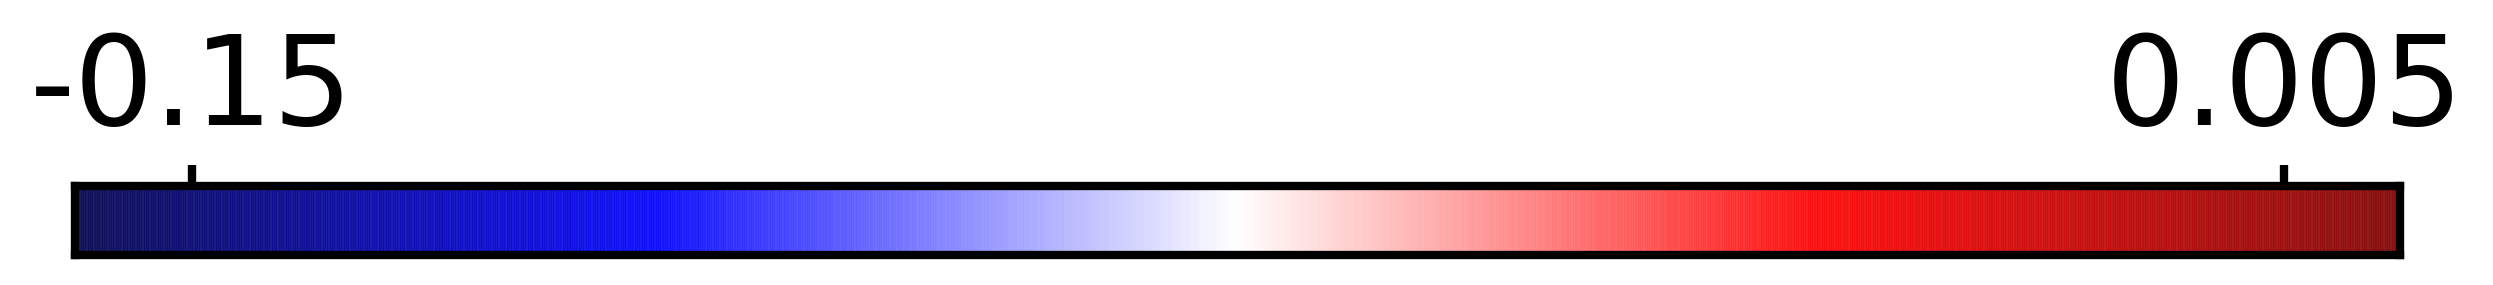

In [ ]:
fig = plt.figure(figsize = (10, 0.3), dpi = 300)
ax = plt.gca()

cmap = plt.get_cmap('seismic')

for i in np.linspace(0, 1, 1000):
    ax.vlines(i, 0, 1, linewidth = 2, alpha = 0.5, color = cmap(i))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

ax.set_xticks(ticks = [0.05, 0.95], labels = [-0.150, 0.005])
ax.set_yticks(ticks = [])
ax.xaxis.tick_top()
ax.tick_params(width = 2, labelsize = 30, length = 5)

plt.show()